# Tarea 3 - Ensamblados y modelos de aprendizaje

Yoel Berant - 201604519-8

Diego Valderas - 201673549-6

## Sección 1 - Ensamblados para regresión

En esta sección, se trata de encontrar un modelo de regresión capaz de predecir la temperatura en grados Fahrenheit (°F) de un día según datos registrados en el día anterior. Se utilizará el dataset *DailyDelhiClimateTrain*, el cual contiene información sobre el clima en Nueva Delhi entre el 2013 y el 2016 [[1]](#refs). Como variantes a considerar se usarán tanto datos meteorológicos (la temperatura, la humedad, la velocidad del viendo y la presión del día anterior) como datos que tengan relación con la fecha (el mes, el año (considerando el cambio climático) la estación del año).

In [1]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
#df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo el dia de la semana no importa la verdad
df['year'] = df['date'].dt.year #considerando el cambio climatico, el año es importante
df['month'] = df['date'].dt.month #1:enero, 12: diciembre

#estaciones (en delhi, hemisferio norte. A la primavera se le llama "rainy"), one hot.
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable



FileNotFoundError: File b'DailyDelhiClimateTrain.csv' does not exist

El conjunto de entrenamiento en este caso corresponderá a los primeros 1000 datos del data set, ordenados aleatoriamente. Los datos de validación corresponden a los 461 ejemplos restantes.

In [ ]:
#matrices de entrenamiento->primeros 1000 ejemplos, en orden aleatorio
y = df.pop("y_value").values
X = df.values 
x_train = X[:1000]
y_train = y[:1000]
x_val = X[1000:]
y_val = y[1000:]
#print(len(X_val))->461
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

En este caso, para construir nuestros modelos de regresión, utilizaremos técnicas de ensamblaje, las cuales consisten básicamente en combinar varios modelos en uno solo.

### a) 
A continuación, se hará un breve análisis de los datos a trabajar.

In [ ]:
#a)descripcion - ??????
df.describe()

In [ ]:
df[:10]#los primeros 10 datos

Al parecer, los datos vienen ordenados por fecha, lo cual ahora resultará muy útil pues, a continuación, se grafican las temperaturas registradas según la fecha:

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.title('temperaturas registradas de datos, orderandos por fecha')
plt.ylabel('temperatura')
plt.xlabel('día')
plt.plot(range(len(y)),y)
plt.show()

El gráfico claramente evidencia una relación entre la época del año y la temperatura descrita. No obstante, se presenta un cierto nivel de ruido. 

Es por esto que si bien es una variable importante, la temperatura anterior por si sola no es suficiente para predecir la temperatura del día actual. Es necesario considerar el mes y la época, mas aún cuando el valor a predecir es de regresión y no de clasificación.

Puesto que cada día tiene una fecha única (en formato timestamp), no se considerá a la fecha como un parámetro predictor de los futuros modelos. Es por esto que se elimina este valor de los datos. Tampoco se tomará en cuenta los años, debido a que, según el gráfico, no parece existir una diferencia significativa de temperaturas entre los años (se puede ver la "forma" de cada año en el gráfico, considerando que un año tiene 365 días).

In [ ]:
import numpy as np
#borrar fechas exactas
X_train=np.delete(x_train,0,1)
X_val=np.delete(x_val,0,1)
#borrar años
X_train=np.delete(X_train,4,1)
X_val=np.delete(X_val,4,1)

### b)
Uno de los métodos de aprendizaje que más se usan con ensamblados son los árboles de decisión. A continuación, se evaluará el desempeño obtenido al usar arboles de decisión para regresión sin usar esta técnica. Usaremos tanto un árbol regularizado (con una profundidad máxima, número mínimo de nodos para Split y numero mínimo de nodos en una hoja fijos) como uno no regularizado. Un beneficio de usar árboles de decisión es que no es necesario escalar o normalizar los datos de entrada, puesto que los algoritmos que se encargan de realizar las particiones no requieren de un escalamiento ya que solo necesitan elegir una variable y fijar en ella un punto de split.

In [ ]:
from sklearn.tree import DecisionTreeRegressor as Tree
#arbol no regularizado:
model_unr = Tree() 
model_unr.fit(X_train,y_train)

#arbol regularizado:
model_reg=Tree(max_depth=150,min_samples_split=7,min_samples_leaf=12)  
model_reg.fit(X_train,y_train)




En este problema se usará como métrica de error el *Root Mean Squared Error*, que corresponde a la raíz al cuadrada del promedio de los errores al cuadrado:

$$
RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\hat{y_{i}}-y_{i})^{2}}
$$

In [ ]:
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )

A continuación se evaluarán los RMSE de entrenamiento y validación de los arboles entrenados en el inciso anterior, y se graficarán tanto los valores de validación como las predicciones hechas por los árboles:

In [ ]:
def plot_RMSE(model,title=None):
    print(title,":")
    y_train_hat = model.predict(X_train)
    y_val_hat = model.predict(X_val)
    print("RMSE train= ",RMSE(y_train,y_train_hat))
    print("RMSE val= ",RMSE(y_val,y_val_hat))
    plt.figure(figsize=(8,5))
    plt.title("predicciones de temperatura del conjunto de validacion y sus valores reales")
    plt.xlabel("días")
    plt.title(title)
    plt.plot(y_val, '.-' ,label="True values")
    plt.plot(y_val_hat, '.-' ,label="Pred values")
    plt.legend()
    plt.show()


plot_RMSE(model_reg,"valores y prediccion con arbol regularizado (maxdepth=100,minsamplessplit=20,minsamplesleaf=7) en validación ")
plot_RMSE(model_unr,"valores y prediccion con arbol no regularizado en validación")

#tldr; no regularizado tiende al overfitting

Lo primero que hay que notar es que el RMSE registrado de entrenamiento con el árbol no regularizado es de 0, pero el RMSE de validación de este mismo árbol es de 2.56 aprox, lo cual es mucho mayor al RMSE de validación del árbol regularizado: 1.783. Si bien el RMSE de entrenamiento del árbol regularizado (1.45) es mayor al del árbol no regularizado (0), no existe tanta diferencia entre este y el RMSE de validación del árbol regularizado. En otras palabras, un árbol no regularizado produce overfitting.

Por otro lado, considerando que el RMSE de validación es menor en el árbol regularizado, podemos observar en sus gráficos que los valores de predicción se asemejan más a los verdaderos en el árbol regularizado, aunque en ninguno de los gráficos se observa un error de predicción significativo.

### d)
La primera técnica de ensamblado es el bagging [[2]](#refs). Esta consiste en simular un espacio de muestra mucho más grande al que se tiene a partir de este, generando varias muestras aleatorias con datos de la muestra original, los cuales se pueden repetir o pueden no salir: técnica conocida como *bootstrap*. Cada muestra se utilizará para entrenar un modelo de aprendizaje: en este caso, arboles de regresión regularizados o no regularizados.

Finalmente, para predecir un dato, se pasa por todos los modelos de aprendizaje (arboles) y se promedian las predicciones realizados por estos (en caso de que los modelos fueran de clasificación en lugar de regresión, se elegiría la clase más predicha por los modelos).

<img src="http://cdn.differencebetween.net/wp-content/uploads/2019/09/Difference-Between-Bagging-and-Random-Forest-768x494.png" title="Bagging" width="50%" height="30%"  />

A continuación, se entrenaran ensamblados con árboles de regresión tanto regularizados como no regularizados (similar al inciso b)). Se graficarán los RMSE registrados según la cantidad de árboles usados para el ensamblaje (n_estimators).

In [ ]:
from sklearn.ensemble import BaggingRegressor

def compare_bagging(maxDepth=150,minSamplesSplit=7,minSamplesLeaf=12,x=X_train,y=y_train):
    nE=np.arange(5, 100, 5)#nestimators es el numero de arboles distintos en el que se hará la regresion. Esta es una lista de posibles valores
    Turg=[]
    Vurg=[]
    Treg=[]
    Vreg=[]
    print("entrenando y calculando...")
    
    for nEstimators in nE:
        bagging_reg=BaggingRegressor(base_estimator=Tree(max_depth=maxDepth,min_samples_split=minSamplesSplit,min_samples_leaf=minSamplesLeaf),n_estimators=nEstimators,n_jobs=-1)
        bagging_reg.fit(x,y)
        
        y_train_hat_reg=bagging_reg.predict(X_train)
        y_val_hat_reg=bagging_reg.predict(X_val)
        RMSE_train_reg=RMSE(y_train,y_train_hat_reg)
        RMSE_val_reg=RMSE(y_val,y_val_hat_reg)
        Treg.append(RMSE_train_reg)
        Vreg.append(RMSE_val_reg)

        bagging_urg=BaggingRegressor(base_estimator=Tree(),n_estimators=nEstimators,n_jobs=-1)
        bagging_urg.fit(x,y)
        
        y_train_hat_urg=bagging_urg.predict(X_train)
        y_val_hat_urg=bagging_urg.predict(X_val)
        RMSE_train_urg=RMSE(y_train,y_train_hat_urg)
        RMSE_val_urg=RMSE(y_val,y_val_hat_urg) 
        Turg.append(RMSE_train_urg)
        Vurg.append(RMSE_val_urg)
    print("listo!")
    
    plt.figure(figsize=(11,7))
    plt.title("RMSE's de entrenamiento y validacion usando bagging según n_estimators")
    plt.ylabel("RMSE")
    plt.xlabel("n_estimator")
    plt.plot(nE,Vreg,label="RMSE de validacion, arboles regularizados")
    plt.plot(nE,Vurg,label="RMSE de validacion, arboles no regularizados")
    plt.plot(nE,Treg,label="RMSE de entrenamiento, arboles regularizados")
    plt.plot(nE,Turg,label="RMSE de entrenamiento, arboles no regularizados")
    
    print("RMSE de validación con arboles no regularizados mínimo: ",min(Vurg)," nestimator: ",nE[Vurg.index(min(Vurg))])
    print("RMSE de validación con arboles regularizados mínimo: ",min(Vreg)," nestimator: ",nE[Vreg.index(min(Vreg))])
    
    
    plt.legend()
    plt.show()
    return

    
compare_bagging()
#model = BaggingRegressor(base_estimator=Tree(...), n_estimators=..., n_jobs=-1)

Similar a lo ocurrido en el inciso c), se visualiza un claro overfitting cuando se usan arboles no regularizados.
Además, si bien se visualiza al principio del gráfico bajas en los RMSE (más cuando los arboles no están regularizados), luego los valores se mantienen relativamente estables en lugar de ser constantemente decrecientes. Esto sucede debido a que las técnicas de ensamblaje de regresión no reducen tanto el error de predicción de los árboles de aprendizaje, sino que en cambio reducen la varianza del error.

### e)
Otra técnica de ensamblaje que se suele usar es *AdaBoost* [[3]](#refs). A diferencia de bagging, en lugar de remuestrear la muestra original de entrenamiento, comienza a entrenar un modelo (en este caso árbol de regresión regularizado o no regularizado) y, según los errores de predicción obtenidos sobre las instancias de la muestra original, reajusta los pesos de estas y vuelve a entrenar repetidamente modelos, con el fin de que los ejemplos más difíciles de predecir bien (o los que se predicen con más error) se enfaticen más en los árboles siguientes. 

Una consecuencia que conlleva el reajuste de pesos de los ejemplos es que los modelos (arboles) producidos estarán relacionados entre sí, en el sentido de que los errores registrados en un modelo repercutirán en el entrenamiento del modelo siguiente; a diferencia de lo ocurrido en bagging, donde cada árbol es generado aleatoriamente y es independiente a los demás árboles.

Similar al inciso anterior, graficaremos los RMSE's obtenidos al usar esta técnica con árboles de regresión regularizados y no regularizados según el número de árboles.

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def compare_adaboost(maxDepth=150,minSamplesSplit=7,minSamplesLeaf=12,x=X_train,y=y_train):
    nE=np.arange(5, 100, 5)#nestimators es el numero de arboles distintos en el que se hará la regresion. Esta es una lista de posibles valores
    Turg=[]
    Vurg=[]
    Treg=[]
    Vreg=[]
    print("entrenando y calculando...")
    
    for nEstimators in nE:
        ada_reg=AdaBoostRegressor(base_estimator=Tree(max_depth=maxDepth,min_samples_split=minSamplesSplit,min_samples_leaf=minSamplesLeaf),n_estimators=nEstimators)
        ada_reg.fit(x,y)
        
        y_train_hat_reg=ada_reg.predict(X_train)
        y_val_hat_reg=ada_reg.predict(X_val)
        RMSE_train_reg=RMSE(y_train,y_train_hat_reg)
        RMSE_val_reg=RMSE(y_val,y_val_hat_reg)
        Treg.append(RMSE_train_reg)
        Vreg.append(RMSE_val_reg)

        ada_urg=AdaBoostRegressor(base_estimator=Tree(),n_estimators=nEstimators)
        ada_urg.fit(x,y)
        
        y_train_hat_urg=ada_urg.predict(X_train)
        y_val_hat_urg=ada_urg.predict(X_val)
        RMSE_train_urg=RMSE(y_train,y_train_hat_urg)
        RMSE_val_urg=RMSE(y_val,y_val_hat_urg) 
        Turg.append(RMSE_train_urg)
        Vurg.append(RMSE_val_urg)
    print("listo!")
    
    plt.figure(figsize=(11,7))
    plt.title("RMSE's de entrenamiento y validacion usando adaboosting segun n_estimators")
    plt.ylabel("RMSE")
    plt.xlabel("n_estimator")
    plt.plot(nE,Vreg,label="RMSE de validacion, arboles regularizados")
    plt.plot(nE,Vurg,label="RMSE de validacion, arboles no regularizados")
    plt.plot(nE,Treg,label="RMSE de entrenamiento, arboles regularizados")
    plt.plot(nE,Turg,label="RMSE de entrenamiento, arboles no regularizados")
    
    print("RMSE de validación con arboles no regularizados mínimo: ",min(Vurg)," nestimator: ",nE[Vurg.index(min(Vurg))])
    print("RMSE de validación con arboles regularizados mínimo: ",min(Vreg)," nestimator: ",nE[Vreg.index(min(Vreg))])
    
   
    plt.legend()
    plt.show()
    return

    
compare_adaboost()

Tal como ocurre en los incisos c) y d), existe un claro nivel de overfitting cuando se usan árboles de regresión.

En el caso de los RMSE's de entrenamiento, tanto en árboles regularizados como en no regularizados, se nota una baja en los RMSE's a medida que suben los n_estimators (más al principio, luego parece converger), puesto que AdaBoost se empeña en corregir los errores durante el entrenamiento.

En relación con lo ocurrido en bagging, los errores de entrenamiento en AdaBoost (de 1.1 a 1.3 cuando se regulariza y de 0 a 0.3 cuando no) son menores a los registrados en bagging (1.5 aprox al regularizar y 0.7 aprox al no regularizar). Sin embargo, en la validación, los RMSE's registrados en AdaBoost son mayores a los de bagging (aproximadamente 1.8 en AdaBoost tanto cuando se regulariza como cuando no, y aprox 1.7 y 1.6 en bagging, con árboles regularizados y no regularizados respectivamente). Nuevamente, esto sucede porque AdaBoost se enfoca demasiado a corregir errores durante la etapa de entrenamiento. Por lo tanto, si queremos minimizar los errores de validación parece más sensato remuestrear la muestra original como se realizó en bagging que ir reajustando los pesos de los ejemplos de la muestra para minimizar el error de entrenamiento.

Una última cosa interesante que recalcar es que los errores de validación cuando se regulariza y cuando no se regulariza se asemejan.

### f)
Otra técnica famosa de ensamblado que se suele usar para arboles de decisión es *random forest* [[4]](#refs). Esta técnica, aparte de realizar *bootstrap* al igual que en Bagging, se caracteriza por generar arboles de clasificación, omitiendo en cada decisión de partición un grupo de variables seleccionadas aleatoriamente, con el fin de variar el orden de los splits y la repercusión de este en la efectividad de los modelos.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def compare_random_forest(maxDepth=150,minSamplesSplit=7,minSamplesLeaf=12,x=X_train,y=y_train):
    nE=np.arange(5, 100, 5)#nestimators es el numero de arboles distintos en el que se hará la regresion. Esta es una lista de posibles valores
    Turg=[]
    Vurg=[]
    Treg=[]
    Vreg=[]
    print("entrenando y calculando...")
    
    for nEstimators in nE:
        random_reg=RandomForestRegressor(max_depth=maxDepth,min_samples_split=minSamplesSplit,min_samples_leaf=minSamplesLeaf,n_estimators=nEstimators,n_jobs=-1)
        random_reg.fit(x,y)
        
        y_train_hat_reg=random_reg.predict(X_train)
        y_val_hat_reg=random_reg.predict(X_val)
        RMSE_train_reg=RMSE(y_train,y_train_hat_reg)
        RMSE_val_reg=RMSE(y_val,y_val_hat_reg)
        Treg.append(RMSE_train_reg)
        Vreg.append(RMSE_val_reg)

        random_urg=RandomForestRegressor(n_estimators=nEstimators,n_jobs=-1)
        random_urg.fit(x,y)
        
        y_train_hat_urg=random_urg.predict(X_train)
        y_val_hat_urg=random_urg.predict(X_val)
        RMSE_train_urg=RMSE(y_train,y_train_hat_urg)
        RMSE_val_urg=RMSE(y_val,y_val_hat_urg) 
        Turg.append(RMSE_train_urg)
        Vurg.append(RMSE_val_urg)
    print("listo!")
    plt.figure(figsize=(11,7))
    plt.title("RMSE's de entrenamiento y validacion usando random forest segun n_estimators")
    plt.ylabel("RMSE")
    plt.xlabel("n_estimator")
    plt.plot(nE,Vreg,label="RMSE de validacion, arboles regularizados")
    plt.plot(nE,Vurg,label="RMSE de validacion, arboles no regularizados")
    plt.plot(nE,Treg,label="RMSE de entrenamiento, arboles regularizados")
    plt.plot(nE,Turg,label="RMSE de entrenamiento, arboles no regularizados")
    
    print("RMSE de validación con arboles no regularizados mínimo: ",min(Vurg)," nestimator: ",nE[Vurg.index(min(Vurg))])
    print("RMSE de validación con arboles regularizados mínimo: ",min(Vreg)," nestimator: ",nE[Vreg.index(min(Vreg))])
    
    plt.legend()
    plt.show()
    return

    
compare_random_forest()
#model_unr = RandomForestRegressor(n_estimators=..., n_jobs=-1)

Como siempre, se produce overfitting cuando no se regulan los árboles. Además, los RMSE's de entrenamiento y validación de arboles regularizados son muy similares (bajo overfitting).

### g) 

El *OOB error* (*out of bag error*) es el error que se obtiene cuando, durante la aplicación de bootstrap durante métodos como bagging y random forest, se evalúan en cada modelo, las instancias no incluidas en la muestra usada. Recordemos que en bootstrap, para cada modelo se crea una muestra de igual largo que la muestra original (el conjunto de entrenamiento), y se incluyen instancias de la muestra original elegidas aleatoria e independientemente. Como se pueden repetir las instancias, una porción de la muestra original no es incluida en cada muestra generada (aproximadamente un tercio de la muestra cuando el número de instancias es grande); esta porción es evaluada en el modelo correspondiente para obtener el OOB error.

A continuación, se graficarán los OOB errors obtenidos usando bagging y random forest según número de árboles (n_estimators), así como los errores de validación obtenidos.

In [ ]:
def compare_oob_error(maxDepth=100,minSamplesSplit=20,minSamplesLeaf=7,x=X_train,y=y_train):
    OOBs_reg_bag=[]
    Vals_reg_bag=[]
 
    OOBs_reg_rdm=[]
    Vals_reg_rdm=[]
    
    nE=np.arange(10,200,5)
    print("entrenando y calculando")
    for nEstimators in nE:
        bagging_reg=BaggingRegressor(base_estimator=Tree(max_depth=maxDepth,min_samples_split=minSamplesSplit,min_samples_leaf=minSamplesLeaf),n_estimators=nEstimators,n_jobs=-1,oob_score=True)
        bagging_reg.fit(x,y)

        random_reg=RandomForestRegressor(max_depth=maxDepth,min_samples_split=minSamplesSplit,min_samples_leaf=minSamplesLeaf,n_estimators=nEstimators,n_jobs=-1,oob_score=True)
        random_reg.fit(x,y)
        
        
        OOBs_reg_bag.append(1-bagging_reg.oob_score_)
        Vals_reg_bag.append(1-bagging_reg.score(X_val,y_val))

        OOBs_reg_rdm.append(1-random_reg.oob_score_)
        Vals_reg_rdm.append(1-random_reg.score(X_val,y_val))
    print("listo!")
        
    plt.figure(figsize=(11,7))
    plt.title("errores OOB's y errores de validacion en tecnicas de bootstrap segun n_estimators (arboles regularizados)")
    plt.ylabel("error")
    plt.xlabel("n_estimator")
    
    plt.plot(nE,OOBs_reg_bag,label="error de OOB con bagging")
    plt.plot(nE,Vals_reg_bag,label="error de validacion con bagging")

    plt.plot(nE,OOBs_reg_rdm,label="error de OOB con randomforest")
    plt.plot(nE,Vals_reg_rdm,label="error de validacion con random forest")

    
    plt.legend()
    plt.show()   
    
    
compare_oob_error()


Cuando el valor n_estimator es suficientemente grande (mayor a 20), obserbamos que se comporta de manera similar a los errores de validación. Por lo tanto, podemos considerar al OOB error como métrica de generalización cuando n_estimator es lo sufientemente grande.

### h)
Una de las partes más interesantes de los métodos de ensamblado es el cómo se combinan las predicciones hechas por todos los modelos entrenados. En bagging, se realiza un promedio entre todas las predicciones si es un caso de regresión, o se elige la clase más "votada" en una clasificación. En AdaBoost, se ponderan las predicciones de los modelos según los pesos de estos, los cuales dependen de su desempeño en clasificación.

A continuación, se propone otra forma de combinar las predicciones:

Primero, se ordenan los modelos según su desempeño (score). Se debe tener como hiperparámetro un número entre 0 y 1, el cual indicará la porción de modelos que se tomarán en cuenta y, usando solo esa porción, se promediarán las predicciones. Por ejemplo, si el hiperarámetro es igual a 0.6, se promediarán las predicciones hechas por el 60% de los modelos con mayor score.

In [ ]:
#portion=1 -> acepta todos los estimadores
#portion=0
def combine_predictions(predictions,estimators,portion):
    if portion>1:
        portion=1
    elif portion<=0:
        portion=0   
    scores=[es.score(X_val,y_val) for es in estimators]
    dat=list(zip(predictions,scores))
    dat.sort(key=lambda x:x[1],reverse=True)#se ordenan
    
    num_ex=len(predictions[0])
    num_preds=len(predictions)   
    new_predictions=np.zeros(num_ex)
    
    for p in range(num_preds):
        c=p+1
        for ex in range(num_ex):
            new_predictions[ex]+=dat[p][0][ex]
            
        if((p+1)/num_preds >= portion):#excede la porción
            break
        
    #estimators.sort(key=lambda x:x.score(X_val,y_val))
    #print([e.score(X_val,y_val) for e in estimators])
    return list(new_predictions/c)


model=BaggingRegressor(base_estimator=Tree(max_depth=100,min_samples_split=20,min_samples_leaf=7),n_estimators=1000,n_jobs=-1,oob_score=True)
model.fit(X_train,y_train)
list_estimators=model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]

#def combine_predictions(predictions):
 #   predictions.sort(key=lambda x: x.score(X_val,y_val),reverse=False)

In [ ]:
old_predictions=model.predict(X_val)
print("RMSE val (tradicionalmente)= ",RMSE(y_val,old_predictions))

new_predictions = combine_predictions(list_predictions,list_estimators,0.6)
print("RMSE val (con combine predictors)= ",RMSE(y_val, new_predictions))

Usando el 60% de los mejores modelos a partir de un ensamblado bagging de 1000 arboles de desición regularizados, se obtiene un RMSE ligeramente menor (es decir, un mejor modelo).

### i)
Al tener una cantidad grande "T" de modelos en el ensamblado (por ejemplo, T>100), se puede crear un intervalo de 
confianza de una predicción usando las predicciones hechas por los modelos. Esto se puede realizar si se asumen a las predicciones como una distribución Normal, cuyo centro es la media muestral de las predicciones y cuya desviación estándar es la desviación estandar de las predicciones.

A esto se le puede añadir un intervalo de confianza del 95%, es decir, si hacemos una predicción existe un 95% de probabilidades de que caiga en el intervalo. 

A continuación, se visualizan los promedios de las predicciones de validación hechas por los modelos del ensamblado del inciso anterior (en este caso, T=1000), junto con los intervalos de confianza establecidos.

In [ ]:
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.xlabel('ejemplo')
plt.ylabel('prediccion')
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

En el siguente widget, se puede analizar por cada ejemplo de validación la distribución de predicciones hechas por los ensamblados, junto con los intervalos de confianza y la porción de predicciones que encajan con los intervalos (que no debería ser mucho menor a 0.95)

In [ ]:
import seaborn as sns
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

def dist_results(n):
    low,up=norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    plt.figure(figsize=(8,5))
    
    portion=len(np.concatenate(np.where((X_val_est[n]>=low)&(X_val_est[n]<=up)),axis=0))/len(X_val_est[n])
    print('porción de valores entre los límites:',portion)
   
    
    
    sns.distplot(X_val_est[n],kde=False,bins=50)
    plt.axvline(low,0,100,color='m',label='limite inferior = {}'.format(low))
    plt.axvline(up,0,100,color='r',label='limite superior = {}'.format(up))
    plt.title('distribucion de predicciones en ejemplo {}, y limites de intervalo de confianza (95%) segun norma.'.format(n))
    plt.ylabel('frecuencia')
    plt.xlabel('predicciones')
    plt.legend()
    plt.show()
    
interact(dist_results,n=IntSlider(min=0,max=len(X_val)-1,step=1,value=0))

### j) Conclusión

Basándonos nétamente en el RMSE de validación, parece ser que el mejor modelo de regresión con ensamblado corresponde al método bagging que usa el promedio del 60% de modelos con mayor score (o "bagging modificado"), usando 1000 estimadores. 

Así pues, las diferencias de RMSE's entre este método, bagging "clásico" y random forest no son tan grandes, aunque estos 3 modelos resultaron ser más efectivos que AdaBoost, quizás porque este último implica independencia entre los modelos desarrollados durante el entrenamiento. 

Hay que considerar también que aumentar el número de estimadores no necesariamente reduce el error. Es más, el regresor con bagging "clásico" de 1000 estimadores entrega un RMSE de validación mayor a bagging y random forest, con 100 estimadores cada uno.

A continuación, se visualizan las predicciones hechas por bagging modificado, en el conjunto de validación:

In [ ]:
plt.figure(figsize=(11,7))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(new_predictions, '.-' ,label="Pred values")
plt.show()



# Sección 2: Detección de acoso en Twitter

Hoy en día el internet ha generado una ola de nuevas dimensiones en las cuales la interacción social se ve perturbada, y así como cosas buenas traer, también trae las malas; el acoso y los tratos hirientes se mudaron para ser aplicados también por estos nuevos medios, haciéndolos aún más difíciles de combatir dado el anonimato y la poca fiscalización que se tiene en este campo. Sin embargo, las personas encargadas de redes sociales toman riendas en el asunto y se dan la facultad de poder negar acceso a diversas cuentas que presentan estos comportamientos tóxicos. Así es como surge la problemática presentada en esta sección, se solicitó obtener el veredicto final acerca de si un tweet es acoso o no. Adicionado a esto se presenta una problemática extra en los datos relacionado con el desbalance de estos, es decir, cuando se tienen muy pocos ejemplo sobre una clase, comparado con el resto de estas. 

In [2]:
#funcion que le quita todos los caracteres especiales a un string y retorna un numpy array con todas las palabras de esta oracion
def nospace(array):
    out_string = ""
    for wordi in array:
        out_string += re.sub(r'[\W]', '', wordi) + " "#'outstring' es el string que no tiene caracteres especiales, sólo palabras
    values2 = out_string.split() ##a este vector se le quitan los espacios
    words = np.asarray(values2)
    return words


negative_words = [
    'bitch','bitches','slut','sluts','whore','whores','shit','shits','kill','die','murder','rape','raped','violate',
    'violated','nigga','niggaz','niggas','nigro','nigros','nigger','fuck','fucked','fucks','fucker','fuckers','fucking',
    'fuckings','motherfucker','mdfr','mofo','cancer','ass','bitchass','ugly','dork','dumb','broke','yousuck','shitty',
    'lame','dick','pussy','piss','bitchy','kinky','horny','hate','hateful','anger','destroy','demolish','fuckyou','fu',
    'retard','weirdo','weird','freak','poor','stupid','alone','suicide','yourself','crazy','shame','shaming', 'dirty',
    'feminazi','dork','hoes','ho','mfs','cringe','cringy','ashamed','bastard','beaner','chicano','cunt','asshole','dickhead',
    'assface','slave','bitchass','cum','porn','penis','vagina','haters'
]


In [3]:
import pandas as pd
import numpy as np
import re
from numpy import linalg as LA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

#se cargan las palabras vectorizadas
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

#se carga la data de entrenamiento
data = pd.read_csv("./train_data.csv")
data_test = pd.read_csv("./test_input.csv")

El dataset está compuesto por el contenido del tweet, un id respectivo para cada uno y datos binarios acerca si un tweet es considerado acoso o no, si este es de índole indirecto, físico o sexual. 

Fue necesario crear parámetros que nos proporcionen más información acerca de cada tweet. Los parámetros creados fueron: "negative_words", que consiste en un contador de veces que palabras negativas aparecen dentro de un tweet. Todas las palabras del tweet son leídas y se pregunta si acaso alguna de estas se encuentra en una lista con muchas palabras ocupadas para denigrar, herir o que tienen que ver con aspectos que dañan la integridad humana, al aparecer una de estas, el contador aumenta en una unidad; "norm_tweet", que corresponde a la norma de un vector que ubica a todo el tweet dentro de un espacio vectorial, este vector es fabricado a partir de la suma de los vectores que ubican en el mismo espacio vectorial a las palabras que lo componen; "norm_negative", que consiste en una medida similar a la anterior, solo que este vector incluye solo palabras clasificadas como negativas, consideradas así según la misma lista que da origen al parámetro "negative_words". La ciencia que tienen los últimos dos parámetros consiste en dar una especie de noción general acerca de la oración contenida en el tweet, ya que "negative_words" no entrega una noción muy repreentativa de la intención de un tweet ya que muchas veces estas palabras son usadas sin hacer daño, es por esto que todos estos parámetros en conjunto podrían entregar una buena noción que permita diferenciar si acaso existe acoso o no. 

In [4]:
tweets = data['tweet_content']
tweets_2 = data_test['tweet_content']
wordvec = np.empty(data.shape[0])
wordnegvec = np.empty(data.shape[0])
negs = np.zeros(data.shape[0],dtype='int') 

counter = 0
for tweet in tweets:
    words = tweet.split()
    vecword = np.zeros((50,), dtype='float32')
    negvec = np.zeros((50,), dtype='float32')
    neg_counter = 0
    for word in words:
        if word in negative_words:
            neg_counter=neg_counter+1
            try:
                negvec = embeddings_dict[word] + negvec
            except KeyError:
                null=np.zeros((50,), dtype='float32')
                negvec = null + negvec
        try:
            vecword = embeddings_dict[word] + vecword
        except KeyError:
            null=np.zeros((50,), dtype='float32')
            vecword = null + vecword
    norm_tweet=LA.norm(vecword)
    norm_neg_word=LA.norm(negvec)
    wordvec[counter]=norm_tweet
    wordnegvec[counter]=norm_neg_word
    negs[counter]=neg_counter
    counter=counter+1

wordvec_test = np.empty(data_test.shape[0])
wordnegvec_test = np.empty(data_test.shape[0])
negs_test = np.zeros(data_test.shape[0],dtype='int') 
counter=0
for tweet in tweets_2:
    words = tweet.split()
    vecword = np.zeros((50,), dtype='float32')
    negvec = np.zeros((50,), dtype='float32')
    neg_counter = 0
    for word in words:
        if word.lower() in negative_words:
            neg_counter=neg_counter+1
            try:
                negvec = embeddings_dict[word.lower()] + negvec
            except KeyError:
                null=np.zeros((50,), dtype='float32')
                negvec = null + negvec
        try:
            vecword = embeddings_dict[word.lower()] + vecword
        except KeyError:
            null=np.zeros((50,), dtype='float32')
            vecword = null + vecword
    norm_tweet=LA.norm(vecword)
    norm_neg_word=LA.norm(negvec)
    wordvec_test[counter]=norm_tweet
    wordnegvec_test[counter]=norm_neg_word
    negs_test[counter]=neg_counter
    counter=counter+1


In [5]:
data['norm_tweet']=wordvec
data['norm_negative']=wordnegvec
data['negative_words']=negs
data_test['norm_tweet']=wordvec_test
data_test['norm_negative']=wordnegvec_test
data_test['negative_words']=negs_test

In [6]:
fq=[]
porcentage=[]
for i in range(2):
    fq.append(data.loc[data['harassment']==i].shape[0])
for i in range(2):
    porcentage.append(fq[i]/(fq[0]+fq[1]))

print('Cantidad de Tweets de acoso: '+str(fq[1])+', equivalente al '+str(porcentage[1])+'de los datos')
print('Cantidad de Tweets sin acoso: '+str(fq[0])+', equivalente al '+str(porcentage[0])+'de los datos')
print('Cantidad de Tweets en el conjuntos de prueba: '+str(data_test.shape[0]))

Cantidad de Tweets de acoso: 549, equivalente al 0.09626512361914781de los datos
Cantidad de Tweets sin acoso: 5154, equivalente al 0.9037348763808521de los datos
Cantidad de Tweets en el conjuntos de prueba: 1785


## Unsampled Data

En este análisis de los datos fue que se confirmó la baja existencia de ejemplos correspondientes a un tweets acosadores.

Aún así se prosiguió con la implementación de un modelo de predicción, sin antes manipular los datos.

Se eligieron ensamblados de árboles para poder resolver el problema, uno hecho mediante la técnica de bagging y otro implementado directamente como random forest, donde ambos realizan un muestreo de los datos, pero diferenciandose en que random forest, además, remuestrea las caracterpisticas, dando a cada learner usado una perspectiva diferente.

Cabe recalcar que ambos modelos corresponden al tipo de clasificador debido a que buscamos obtener una etiqueta y no un valor continuo.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

train_acc_rf = []
train_recall_rf = []
train_f1_rf = []
train_acc_bagg = []
train_recall_bagg = []
train_f1_bagg = []
MAX_MODELS = 30

x_train = data[['norm_tweet','negative_words','norm_negative']].copy()
y_train = data[['harassment']].copy()
x_test = data_test[['norm_tweet','negative_words','norm_negative']].copy()
for size in range(1,MAX_MODELS):

    base_learner = DecisionTreeClassifier()
    bagging_model = BaggingClassifier(base_estimator = base_learner, n_estimators=size)
    bagging_model.fit(x_train, y_train.values.ravel())

    rf_model = RandomForestClassifier(n_estimators=size)#max_depth=10
    rf_model.fit(x_train, y_train.values.ravel())

    y_pred_bagging = bagging_model.predict(x_test)
    y_pred_rf = rf_model.predict(x_test)
    y_pred_rf_train = rf_model.predict(x_train)
    y_pred_bagging_train = bagging_model.predict(x_train)
    train_acc_bagg.append(bagging_model.score(x_train, y_train.values.ravel()))
    train_acc_rf.append(rf_model.score(x_train, y_train.values.ravel()))
    train_recall_bagg.append(recall_score(y_train, y_pred_bagging_train))
    train_recall_rf.append(recall_score(y_train, y_pred_rf_train))
    train_f1_bagg.append(f1_score(y_train, y_pred_bagging_train))
    train_f1_rf.append(f1_score(y_train, y_pred_rf_train))
    

Mínimo valor de accuracy para BaggingTree: 0.952656496580747
Mínimo valor de accuracy para RandomForest: 0.9554620375241101
Máximo valor de accuracy para BaggingTree: 0.9936875328774329
Máximo valor de accuracy para RandomForest: 0.9942135718043135


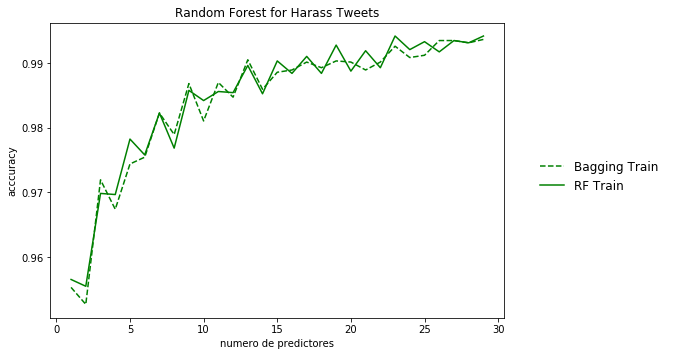

In [8]:
f = plt.figure(figsize=(7,5))
ax = f.add_axes([0.075, 0.08, 0.9, 0.82])
n_predictors = [size for size in range(1,MAX_MODELS)]
ax.plot(n_predictors,train_acc_bagg,'--',color='g',label='Bagging Train')
ax.plot(n_predictors,train_acc_rf,color='g',label='RF Train')

ax.set_xlabel("numero de predictores")
ax.set_ylabel("acccuracy")
ax.set_title("Random Forest for Harass Tweets")

leg = f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)
print('Mínimo valor de accuracy para BaggingTree: '+str(min(train_acc_bagg)))
print('Mínimo valor de accuracy para RandomForest: '+str(min(train_acc_rf)))
print('Máximo valor de accuracy para BaggingTree: '+str(max(train_acc_bagg)))
print('Máximo valor de accuracy para RandomForest: '+str(max(train_acc_rf)))

Mínimo valor de accuracy para BaggingTree: 0.5664845173041895
Mínimo valor de accuracy para RandomForest: 0.6010928961748634
Máximo valor de accuracy para BaggingTree: 0.9544626593806922
Máximo valor de accuracy para RandomForest: 0.9544626593806922


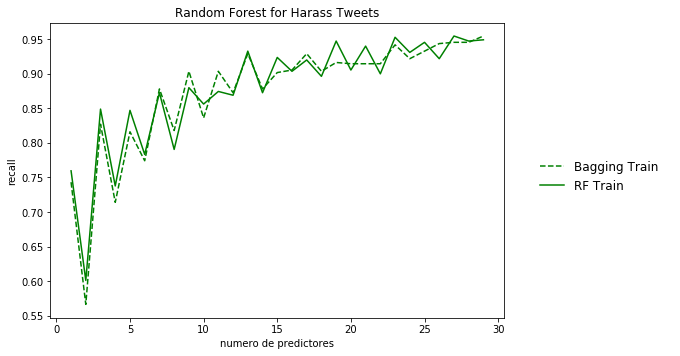

In [9]:
f = plt.figure(figsize=(7,5))
ax2 = f.add_axes([0.080, 0.08, 0.9, 0.82])
ax2.plot(n_predictors,train_recall_bagg,'--',color='g',label='Bagging Train')
ax2.plot(n_predictors,train_recall_rf,color='g',label='RF Train')

ax2.set_xlabel("numero de predictores")
ax2.set_ylabel("recall")
ax2.set_title("Random Forest for Harass Tweets")

leg = f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)
print('Mínimo valor de accuracy para BaggingTree: '+str(min(train_recall_bagg)))
print('Mínimo valor de accuracy para RandomForest: '+str(min(train_recall_rf)))
print('Máximo valor de accuracy para BaggingTree: '+str(max(train_recall_bagg)))
print('Máximo valor de accuracy para RandomForest: '+str(max(train_recall_rf)))


Mínimo valor de accuracy para BaggingTree: 0.6973094170403588
Mínimo valor de accuracy para RandomForest: 0.7221006564551423
Máximo valor de accuracy para BaggingTree: 0.966789667896679
Máximo valor de accuracy para RandomForest: 0.969416126042632


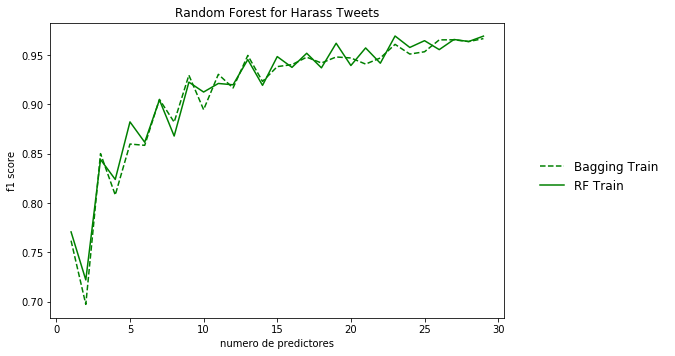

In [10]:
f = plt.figure(figsize=(7,5))
ax3 = f.add_axes([0.090, 0.08, 0.9, 0.82])
ax3.plot(n_predictors,train_f1_bagg,'--',color='g',label='Bagging Train')
ax3.plot(n_predictors,train_f1_rf,color='g',label='RF Train')

ax3.set_xlabel("numero de predictores")
ax3.set_ylabel("f1 score")
ax3.set_title("Random Forest for Harass Tweets")

leg = f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)
print('Mínimo valor de accuracy para BaggingTree: '+str(min(train_f1_bagg)))
print('Mínimo valor de accuracy para RandomForest: '+str(min(train_f1_rf)))
print('Máximo valor de accuracy para BaggingTree: '+str(max(train_f1_bagg)))
print('Máximo valor de accuracy para RandomForest: '+str(max(train_f1_rf)))

Como es de costumbre, la accuracy nos entrega un buen resultado principalmente a que, como son tan pocos los casos en que existe acoso, la mala clasificación no genera mayor efecto negativo en el resultado. 

Se usaron otras métricas como es el "recall" que nos indica cuán bien un modelo es capaz de detectar una clase y la "f1" que es un promedio entre el recall y otra métrica llamada "precision"(cuando confiable es el resultado cuando un modelo responde que un punto pertenece a una clase). Con esta se puede evidenciar un menor rendiemiento que el entregado por el accuracy, así evidenciando los problemas que el desbalance genera en los learners.

Sin embargo al aumentar la cantidad de miembros en el comité de learners se puede ver una gran rendimiento y mejora de parte de ambos modelos.

## Resampled Data

Ahora, a forma de combatir el desbalance, fue que se hizo práctica de una técnica de resampleo siendo esta la creación de datos sintéticos. Gracias a SMOTE, una herramienta proporcionada por una librería de Python, y su algoritmo de vecinos cercanos se puedo generar nueva data útil para entrenar al modelo.

In [11]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27)
X_train, Y_train = sm.fit_sample(x_train, y_train.values.ravel())
y_counter=0
print(Y_train)
for i in Y_train:
    if i == 1:
        y_counter=y_counter+1
print('Cantidad de nuevos ejemplos: '+str(y_counter))
train_acc_srf = []
train_recall_srf = []
train_f1_srf = []
train_acc_sbagg = []
train_recall_sbagg = []
train_f1_sbagg = []

for size in range(1,MAX_MODELS):

    base_learner = DecisionTreeClassifier()
    smote_bagg = BaggingClassifier(base_estimator = base_learner, n_estimators=size)
    smote_rf = RandomForestClassifier(n_estimators=size)
    smote_bagg.fit(X_train, Y_train)
    smote_rf.fit(X_train, Y_train)

    smote_rf_pred = smote_rf.predict(x_test)
    smote_bagg_pred = smote_bagg.predict(x_test)
    
    y_pred_srf_train = smote_rf.predict(X_train)
    y_pred_sbagging_train = smote_bagg.predict(X_train)
    
    train_acc_sbagg.append(smote_bagg.score(X_train, Y_train))
    train_acc_srf.append(smote_rf.score(X_train, Y_train))
    
    train_recall_sbagg.append(recall_score(Y_train, y_pred_sbagging_train))
    train_recall_srf.append(recall_score(Y_train, y_pred_srf_train))
    
    train_f1_sbagg.append(f1_score(Y_train, y_pred_sbagging_train))
    train_f1_srf.append(f1_score(Y_train, y_pred_srf_train))

[0 0 0 ... 1 1 1]
Cantidad de nuevos ejemplos: 5154


Mínimo valor de accuracy para BaggingTree: 0.9098758246022507
Mínimo valor de accuracy para RandomForest: 0.9059953434225844
Máximo valor de accuracy para BaggingTree: 0.9934031819945673
Máximo valor de accuracy para RandomForest: 0.9932091579355841


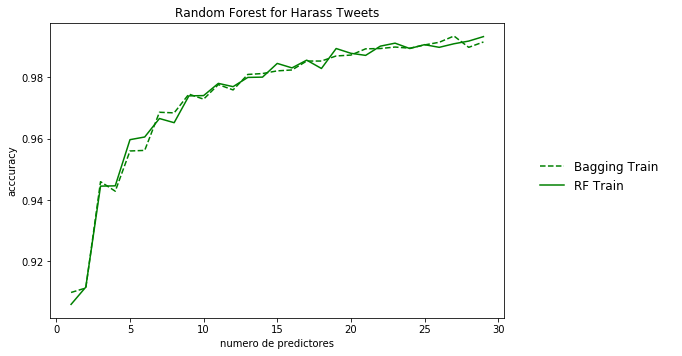

In [12]:
f = plt.figure(figsize=(7,5))
ax = f.add_axes([0.075, 0.08, 0.9, 0.82])
n_predictors = [size for size in range(1,MAX_MODELS)]
ax.plot(n_predictors,train_acc_sbagg,'--',color='g',label='Bagging Train')
ax.plot(n_predictors,train_acc_srf,color='g',label='RF Train')

ax.set_xlabel("numero de predictores")
ax.set_ylabel("acccuracy")
ax.set_title("Random Forest for Harass Tweets")

leg = f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)
print('Mínimo valor de accuracy para BaggingTree: '+str(min(train_acc_sbagg)))
print('Mínimo valor de accuracy para RandomForest: '+str(min(train_acc_srf)))
print('Máximo valor de accuracy para BaggingTree: '+str(max(train_acc_sbagg)))
print('Máximo valor de accuracy para RandomForest: '+str(max(train_acc_srf)))

Mínimo valor de accuracy para BaggingTree: 0.8443927046953822
Mínimo valor de accuracy para RandomForest: 0.8445867287543656
Máximo valor de recall para BaggingTree: 0.9930151338766007
Máximo valor de recall para RandomForest: 0.9930151338766007


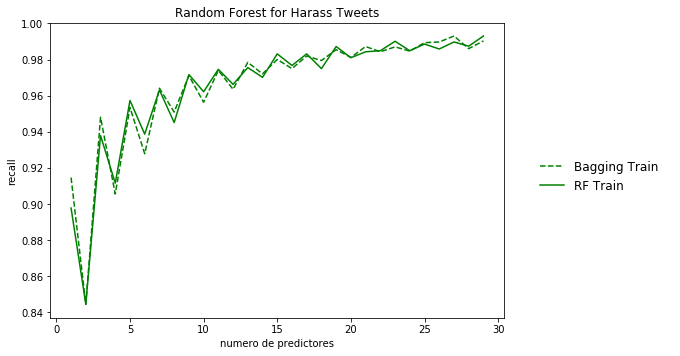

In [13]:
f = plt.figure(figsize=(7,5))
ax2 = f.add_axes([0.080, 0.08, 0.9, 0.82])
ax2.plot(n_predictors,train_recall_sbagg,'--',color='g',label='Bagging Train')
ax2.plot(n_predictors,train_recall_srf,color='g',label='RF Train')

ax2.set_xlabel("numero de predictores")
ax2.set_ylabel("recall")
ax2.set_title("Random Forest for Harass Tweets")

leg = f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)
print('Mínimo valor de accuracy para BaggingTree: '+str(min(train_recall_sbagg)))
print('Mínimo valor de accuracy para RandomForest: '+str(min(train_recall_srf)))
print('Máximo valor de recall para BaggingTree: '+str(max(train_recall_sbagg)))
print('Máximo valor de recall para RandomForest: '+str(max(train_recall_srf)))

Mínimo valor de accuracy para BaggingTree: 0.9049698482012892
Mínimo valor de accuracy para RandomForest: 0.9052137337376504
Máximo valor de F1 para BaggingTree: 0.9934006211180124
Máximo valor de F1 para RandomForest: 0.9932078400931497


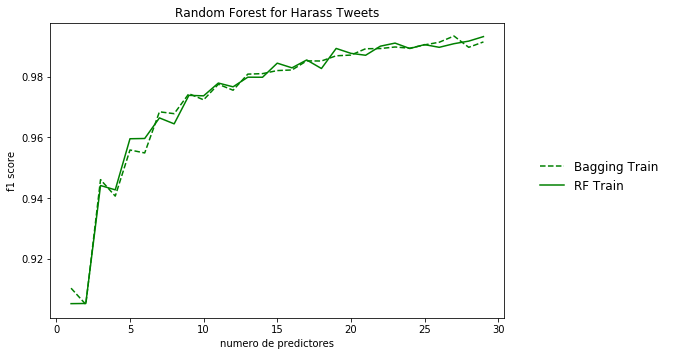

In [14]:
f = plt.figure(figsize=(7,5))
ax3 = f.add_axes([0.090, 0.08, 0.9, 0.82])
ax3.plot(n_predictors,train_f1_sbagg,'--',color='g',label='Bagging Train')
ax3.plot(n_predictors,train_f1_srf,color='g',label='RF Train')

ax3.set_xlabel("numero de predictores")
ax3.set_ylabel("f1 score")
ax3.set_title("Random Forest for Harass Tweets")

leg = f.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)
print('Mínimo valor de accuracy para BaggingTree: '+str(min(train_f1_sbagg)))
print('Mínimo valor de accuracy para RandomForest: '+str(min(train_f1_srf)))
print('Máximo valor de F1 para BaggingTree: '+str(max(train_f1_sbagg)))
print('Máximo valor de F1 para RandomForest: '+str(max(train_f1_srf)))

Con la data resampleada se puede ver una clara mejora para ambos modelos, teniendo mejor rendimiento en el comienzo y a medida que aumenta el comite, al igual que en lo modelos pasados este aumenta aún más, pero ambos terminando teniendo una capacidad de predicción similar cuando el numero de miembros es grande confirmando de este modo el argumento pricipal que ocupan los métodos ensamblados

In [15]:
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+smote_rf_pred.shape[0])
df_aux["harassment"] = smote_rf_pred
df_aux.to_csv("test_estimation.csv", index=False)

In [16]:
datadura = pd.read_csv("./test_estimation.csv")
datadura

,id,harassment
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0
5,6,0
6,7,1
7,8,0
8,9,0
9,10,0


<a id="refs"></a>
## Referencias
[1] https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data    
[2] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html   
[3] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html?highlight=adaboost#sklearn.ensemble.AdaBoostRegressor   
[4] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor